In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import os
import glob
import xml.etree.ElementTree as ET
import cv2
import numpy as np
import random
from sklearn.svm import LinearSVC
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

## Data Extraction

In [3]:
PROJECT_ROOT = "/content/drive/MyDrive/COS429/cv_final_project"
DATASET_ROOT = os.path.join(PROJECT_ROOT, "archive")

print(os.listdir(DATASET_ROOT))

['Val', 'Test', 'Train']


In [4]:
def get_split_dirs(split):
    """
    split: 'train', 'val', or 'test'
    Returns: (images_dir, annots_dir, list_file)
    """
    # Adjust for capitalized 'Train' directory
    if split == 'train':
        split_root = os.path.join(DATASET_ROOT, 'Train')
    elif split == 'val':
        split_root = os.path.join(DATASET_ROOT, 'Val')
    else:
        split_root = os.path.join(DATASET_ROOT, 'Test')

    images_dir = os.path.join(split_root, split.capitalize(), "JPEGImages") # because dataset structure is ex: Train/Train/...
    annots_dir = os.path.join(split_root, split.capitalize(), "Annotations")
    list_file = os.path.join(split_root, split.capitalize(), f"{split}.txt")
    return images_dir, annots_dir, list_file

for s in ["train", "val", "test"]:
    images_dir, annots_dir, list_file = get_split_dirs(s)
    print(f"{s} images dir:    {images_dir}")
    print(f"{s} annots dir:    {annots_dir}")
    print(f"{s} list file:     {list_file}")
    print()

RESULTS_DIR = os.path.join(PROJECT_ROOT, "results_hog")
os.makedirs(RESULTS_DIR, exist_ok=True)
print("Results will be saved to:", RESULTS_DIR)

train images dir:    /content/drive/MyDrive/COS429/cv_final_project/archive/Train/Train/JPEGImages
train annots dir:    /content/drive/MyDrive/COS429/cv_final_project/archive/Train/Train/Annotations
train list file:     /content/drive/MyDrive/COS429/cv_final_project/archive/Train/Train/train.txt

val images dir:    /content/drive/MyDrive/COS429/cv_final_project/archive/Val/Val/JPEGImages
val annots dir:    /content/drive/MyDrive/COS429/cv_final_project/archive/Val/Val/Annotations
val list file:     /content/drive/MyDrive/COS429/cv_final_project/archive/Val/Val/val.txt

test images dir:    /content/drive/MyDrive/COS429/cv_final_project/archive/Test/Test/JPEGImages
test annots dir:    /content/drive/MyDrive/COS429/cv_final_project/archive/Test/Test/Annotations
test list file:     /content/drive/MyDrive/COS429/cv_final_project/archive/Test/Test/test.txt

Results will be saved to: /content/drive/MyDrive/COS429/cv_final_project/results_hog


In [5]:
def parse_annotation(xml_path):
    """
    Parse a VOC-style XML file.

    Returns list of dicts:
      [{ 'bbox': (xmin,ymin,xmax,ymax), 'label': str }, ...]
    """
    import xml.etree.ElementTree as ET

    tree = ET.parse(xml_path)
    root = tree.getroot()

    objects = []
    for obj in root.findall('object'):
        name = obj.find('name').text.lower().strip() # tag / label
        bbox = obj.find('bndbox')
        xmin = int(float(bbox.find('xmin').text))
        ymin = int(float(bbox.find('ymin').text))
        xmax = int(float(bbox.find('xmax').text))
        ymax = int(float(bbox.find('ymax').text))
        objects.append({
            'label': name,
            'bbox': (xmin, ymin, xmax, ymax),
        })
    return objects

In [6]:
person_labels    = {'person'}
nonperson_labels = {'person-like'}

def map_label_to_binary(name):
    """
    Returns 1 for person, 0 for non-person, or None to ignore.
    """
    name = name.lower()
    if name in person_labels:
        return 1
    if name in nonperson_labels:
        return 0
    print("there's a third label called ", name)
    return None


def resolve_image_path(images_dir, base_id):
    """
    base_id is like 'image (7)' from train.txt / val.txt / test.txt.
    """
    ext = ".jpg"

    candidate = os.path.join(images_dir, base_id + ext)
    if os.path.exists(candidate):
      return candidate
    return None

# Import tqdm for progress bar
from tqdm.notebook import tqdm

def load_split_samples(split):
    """
    Load all bounding boxes for a given split ('train', 'val', 'test').

    Returns: list of dicts with keys:
      'img_path', 'bbox', 'label', 'y', 'split'
    """
    images_dir, annots_dir, list_file = get_split_dirs(split)

    # Load list of image IDs from txt file (e.g. 'image (7)')
    with open(list_file, 'r') as f:
        ids = [line.strip() for line in f if line.strip()]

    samples_grouped = [] # List to store grouped samples
    total_positives = 0
    total_negatives = 0

    # Wrap the iteration with tqdm to show progress
    for img_id in tqdm(ids, desc=f'Loading {split} samples'):
        base = os.path.splitext(img_id)[0]  # strip extension if present

        # Resolve xml path using base id
        xml_path = os.path.join(annots_dir, base + ".xml")
        if not os.path.exists(xml_path):
            # print(f"[{split}] Warning: XML not found for", xml_path)
            continue

        objs = parse_annotation(xml_path)

        # Resolve image path using base id (ignore XML filename)
        img_path = resolve_image_path(images_dir, base)
        if img_path is None:
            print(f"[{split}] Warning: no image found for ID '{base}'")
            continue

        current_image_annotations = []
        # for each of the bounding boxes
        for o in objs:
            y = map_label_to_binary(o['label'])
            if y is None:
                continue  # skip labels we don't care about

            current_image_annotations.append({
                'bbox': o['bbox'],
                'label': o['label'],
                'y': y, # 1 if person, 0 if non-person label
            })
            if y == 1:
                total_positives += 1
            else:
                total_negatives += 1

        if current_image_annotations:
            samples_grouped.append({
                'img_path': img_path,
                'split': split,
                'annotations': current_image_annotations,
            })

    print(f"{split}: loaded {len(samples_grouped)} images with annotations")
    print(f"  total positives (person):     {total_positives}")
    print(f"  total negatives (non-person): {total_negatives}")
    return samples_grouped

In [7]:
train_samples = load_split_samples("train")
val_samples   = load_split_samples("val")
test_samples  = load_split_samples("test")

labels_in_data = sorted({label for sample_group in (train_samples + val_samples + test_samples) for annotation in sample_group['annotations'] for label in [annotation['label']]})
print("Labels present across all splits:", labels_in_data)

Loading train samples:   0%|          | 0/944 [00:00<?, ?it/s]

train: loaded 944 images with annotations
  total positives (person):     1106
  total negatives (non-person): 960


Loading val samples:   0%|          | 0/160 [00:00<?, ?it/s]

val: loaded 160 images with annotations
  total positives (person):     203
  total negatives (non-person): 130


Loading test samples:   0%|          | 0/235 [00:00<?, ?it/s]

test: loaded 235 images with annotations
  total positives (person):     317
  total negatives (non-person): 278
Labels present across all splits: ['person', 'person-like']


In [8]:
print(train_samples[0])

{'img_path': '/content/drive/MyDrive/COS429/cv_final_project/archive/Train/Train/JPEGImages/image (1).jpg', 'split': 'train', 'annotations': [{'bbox': (158, 44, 289, 167), 'label': 'person', 'y': 1}]}


{'img_path': '/content/drive/MyDrive/COS429/cv_final_project/archive/Train/Train/JPEGImages/image (111).jpg', 'split': 'train', 'annotations': [{'bbox': (3, 1, 351, 500), 'label': 'person', 'y': 1}]}


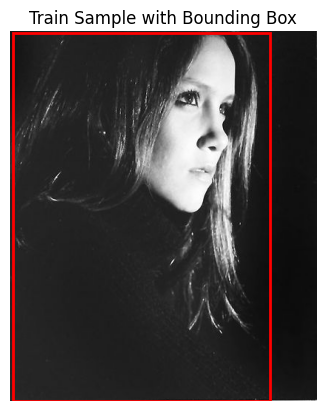

In [9]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from PIL import Image

# Get the first sample from train_samples
sample = train_samples[14] # Using the same index as before to maintain context
print(sample)

# Load the image
image = Image.open(sample['img_path'])

# Create a figure and an axes object
fig, ax = plt.subplots(1)

# Display the image
ax.imshow(image)

# Iterate through all annotations and draw each bounding box
for annotation in sample['annotations']:
    xmin, ymin, xmax, ymax = annotation['bbox']
    rect = patches.Rectangle((xmin, ymin), xmax - xmin, ymax - ymin,
                             linewidth=2,
                             edgecolor='r',
                             facecolor='none')
    ax.add_patch(rect)

# Turn off axis ticks
ax.axis('off')

# Set title
ax.set_title('Train Sample with Bounding Box')

# Display the plot
plt.show()

# HOG (Dalal & Triggs)

In [10]:
WIN_SIZES     = [(64, 128), (96, 160)]
BLOCK_SIZES   = [(16, 16), (24, 24)]
BLOCK_STRIDES = [(8, 8), (12, 12)]
CELL_SIZES    = [(8, 8), (12, 12)]
NBINS_OPTIONS = [9, 12]

In [11]:
import cv2
import numpy as np

# Feature Extraction
def compute_parameterized_hog_feature(img, win_size=(64, 128), block_size=(16, 16), block_stride=(8, 8), cell_size=(8, 8), nbins=9):
    if img is None:
        raise ValueError("compute_parameterized_hog_feature: got None image")

    # Instantiate HOGDescriptor with provided parameters
    hog_param = cv2.HOGDescriptor(win_size, block_size, block_stride, cell_size, nbins)

    if len(img.shape) == 3:
        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    else:
        gray = img

    # Resize crop to fixed HOG window
    resized = cv2.resize(gray, win_size)
    feat = hog_param.compute(resized)  # column vector
    return feat.flatten()

In [12]:
import numpy as np
import cv2, itertools
from tqdm.notebook import tqdm

def build_hog_features_with_params(samples_grouped, split_name, hog_params):
    """
    Given list of sample_groups (each representing an image with its annotations)
    compute HOG features for each bounding box using specified parameters.
    """

    X_list = []
    y_list = []
    processed_boxes_count = 0

    win_size = hog_params['win_size']
    block_size = hog_params['block_size']
    block_stride = hog_params['block_stride']
    cell_size = hog_params['cell_size']
    nbins = hog_params['nbins']

    for i, sample_group in enumerate(tqdm(samples_grouped, desc=f'Building {split_name} features with HOG params {hog_params}')):
        img_path = sample_group['img_path']
        img = cv2.imread(img_path)
        if img is None:
            # some image numbers are unavailable
            continue

        h, w = img.shape[:2]

        for annotation in sample_group['annotations']:
            xmin, ymin, xmax, ymax = annotation['bbox']
            y = annotation['y']

            # clamp to image bounds
            xmin = max(0, xmin)
            ymin = max(0, ymin)
            xmax = min(w - 1, xmax)
            ymax = min(h - 1, ymax)

            if xmax <= xmin or ymax <= ymin:
                continue

            crop = img[ymin:ymax, xmin:xmax]

            # use the parameterized HOG feature computation
            feat = compute_parameterized_hog_feature(
                crop, win_size=win_size, block_size=block_size,
                block_stride=block_stride, cell_size=cell_size, nbins=nbins
            )

            X_list.append(feat)
            y_list.append(y)
            processed_boxes_count += 1

    X = np.array(X_list, dtype=np.float32)
    y = np.array(y_list, dtype=np.int32)
    print(f"[{split_name}] X shape: {X.shape}, y shape: {y.shape} for HOG params {hog_params}")
    return X, y


In [13]:
from sklearn.svm import LinearSVC
from sklearn.metrics import classification_report, roc_auc_score, average_precision_score, accuracy_score
import os

hog_tuning_results = []

# generate all possible combinations of HOG parameters
param_combinations = itertools.product(
    WIN_SIZES,
    BLOCK_SIZES,
    BLOCK_STRIDES,
    CELL_SIZES,
    NBINS_OPTIONS
)

for i, (win_size, block_size, block_stride, cell_size, nbins) in enumerate(param_combinations):
    print(f"\n Running HOG parameter combination {i+1} ")
    current_hog_params = {
        'win_size': win_size,
        'block_size': block_size,
        'block_stride': block_stride,
        'cell_size': cell_size,
        'nbins': nbins
    }
    print(f"Parameters: {current_hog_params}")

    # check for HOG parameter validity before proceeding
    if (block_size[0] % cell_size[0] != 0 or block_size[1] % cell_size[1] != 0):
        print(f"Skipping invalid HOG parameters: block_size ({block_size}) must be divisible by cell_size ({cell_size})")
        continue

    if ((win_size[0] - block_size[0]) % block_stride[0] != 0 or \
        (win_size[1] - block_size[1]) % block_stride[1] != 0):
        print(f"Skipping invalid HOG parameters: (win_size - block_size) ({win_size[0]-block_size[0]}, {win_size[1]-block_size[1]}) must be divisible by block_stride ({block_stride})")
        continue

    # extract HOG features for train and val sets
    X_train_tuned, y_train_tuned = build_hog_features_with_params(train_samples, "train", current_hog_params)
    X_val_tuned, y_val_tuned = build_hog_features_with_params(val_samples, "val", current_hog_params)

    # instantiate and train LinearSVC model
    clf_tuned = LinearSVC(
        C=0.01,
        class_weight='balanced',
        max_iter=5000,
        random_state=42 # for reproducibility
    )
    clf_tuned.fit(X_train_tuned, y_train_tuned)

    # evaluate on validation set
    y_pred_val_tuned = clf_tuned.predict(X_val_tuned)
    scores_val_tuned = clf_tuned.decision_function(X_val_tuned)

    # calculate metrics
    accuracy = accuracy_score(y_val_tuned, y_pred_val_tuned)
    report = classification_report(y_val_tuned, y_pred_val_tuned, target_names=["nonhuman", "person"], output_dict=True)
    roc_auc = roc_auc_score(y_val_tuned, scores_val_tuned)
    pr_auc = average_precision_score(y_val_tuned, scores_val_tuned)

    # store results
    hog_tuning_results.append({
        'params': current_hog_params,
        'accuracy': accuracy,
        'f1_nonhuman': report['nonhuman']['f1-score'],
        'f1_person': report['person']['f1-score'],
        'roc_auc': roc_auc,
        'pr_auc': pr_auc
    })

    print(f"Validation Accuracy: {accuracy:.4f}")
    print(f"Validation F1-score (nonhuman): {report['nonhuman']['f1-score']:.4f}")
    print(f"Validation F1-score (person): {report['person']['f1-score']:.4f}")
    print(f"Validation ROC AUC: {roc_auc:.4f}")
    print(f"Validation PR AUC: {pr_auc:.4f}")

print("\nHOG parameter tuning complete.")
print(f"Total combinations evaluated: {len(hog_tuning_results)}")
print("Results stored in 'hog_tuning_results' list.")



 Running HOG parameter combination 1 
Parameters: {'win_size': (64, 128), 'block_size': (16, 16), 'block_stride': (8, 8), 'cell_size': (8, 8), 'nbins': 9}


Building train features with HOG params {'win_size': (64, 128), 'block_size': (16, 16), 'block_stride': (8, 8)…

[train] X shape: (2066, 3780), y shape: (2066,) for HOG params {'win_size': (64, 128), 'block_size': (16, 16), 'block_stride': (8, 8), 'cell_size': (8, 8), 'nbins': 9}


Building val features with HOG params {'win_size': (64, 128), 'block_size': (16, 16), 'block_stride': (8, 8), …

[val] X shape: (333, 3780), y shape: (333,) for HOG params {'win_size': (64, 128), 'block_size': (16, 16), 'block_stride': (8, 8), 'cell_size': (8, 8), 'nbins': 9}
Validation Accuracy: 0.7027
Validation F1-score (nonhuman): 0.6551
Validation F1-score (person): 0.7388
Validation ROC AUC: 0.7815
Validation PR AUC: 0.8332

 Running HOG parameter combination 2 
Parameters: {'win_size': (64, 128), 'block_size': (16, 16), 'block_stride': (8, 8), 'cell_size': (8, 8), 'nbins': 12}


Building train features with HOG params {'win_size': (64, 128), 'block_size': (16, 16), 'block_stride': (8, 8)…

[train] X shape: (2066, 5040), y shape: (2066,) for HOG params {'win_size': (64, 128), 'block_size': (16, 16), 'block_stride': (8, 8), 'cell_size': (8, 8), 'nbins': 12}


Building val features with HOG params {'win_size': (64, 128), 'block_size': (16, 16), 'block_stride': (8, 8), …

[val] X shape: (333, 5040), y shape: (333,) for HOG params {'win_size': (64, 128), 'block_size': (16, 16), 'block_stride': (8, 8), 'cell_size': (8, 8), 'nbins': 12}
Validation Accuracy: 0.7087
Validation F1-score (nonhuman): 0.6548
Validation F1-score (person): 0.7481
Validation ROC AUC: 0.7934
Validation PR AUC: 0.8379

 Running HOG parameter combination 3 
Parameters: {'win_size': (64, 128), 'block_size': (16, 16), 'block_stride': (8, 8), 'cell_size': (12, 12), 'nbins': 9}
Skipping invalid HOG parameters: block_size ((16, 16)) must be divisible by cell_size ((12, 12))

 Running HOG parameter combination 4 
Parameters: {'win_size': (64, 128), 'block_size': (16, 16), 'block_stride': (8, 8), 'cell_size': (12, 12), 'nbins': 12}
Skipping invalid HOG parameters: block_size ((16, 16)) must be divisible by cell_size ((12, 12))

 Running HOG parameter combination 5 
Parameters: {'win_size': (64, 128), 'block_size': (16, 16), 'block_stride': (12, 12), 'cell_size': (8, 8), 'nbins': 9}
Skipping 

Building train features with HOG params {'win_size': (64, 128), 'block_size': (24, 24), 'block_stride': (8, 8)…

[train] X shape: (2066, 6804), y shape: (2066,) for HOG params {'win_size': (64, 128), 'block_size': (24, 24), 'block_stride': (8, 8), 'cell_size': (8, 8), 'nbins': 9}


Building val features with HOG params {'win_size': (64, 128), 'block_size': (24, 24), 'block_stride': (8, 8), …

[val] X shape: (333, 6804), y shape: (333,) for HOG params {'win_size': (64, 128), 'block_size': (24, 24), 'block_stride': (8, 8), 'cell_size': (8, 8), 'nbins': 9}
Validation Accuracy: 0.7087
Validation F1-score (nonhuman): 0.6620
Validation F1-score (person): 0.7441
Validation ROC AUC: 0.8018
Validation PR AUC: 0.8512

 Running HOG parameter combination 10 
Parameters: {'win_size': (64, 128), 'block_size': (24, 24), 'block_stride': (8, 8), 'cell_size': (8, 8), 'nbins': 12}


Building train features with HOG params {'win_size': (64, 128), 'block_size': (24, 24), 'block_stride': (8, 8)…

[train] X shape: (2066, 9072), y shape: (2066,) for HOG params {'win_size': (64, 128), 'block_size': (24, 24), 'block_stride': (8, 8), 'cell_size': (8, 8), 'nbins': 12}


Building val features with HOG params {'win_size': (64, 128), 'block_size': (24, 24), 'block_stride': (8, 8), …

[val] X shape: (333, 9072), y shape: (333,) for HOG params {'win_size': (64, 128), 'block_size': (24, 24), 'block_stride': (8, 8), 'cell_size': (8, 8), 'nbins': 12}
Validation Accuracy: 0.7147
Validation F1-score (nonhuman): 0.6713
Validation F1-score (person): 0.7480
Validation ROC AUC: 0.8122
Validation PR AUC: 0.8571

 Running HOG parameter combination 11 
Parameters: {'win_size': (64, 128), 'block_size': (24, 24), 'block_stride': (8, 8), 'cell_size': (12, 12), 'nbins': 9}


Building train features with HOG params {'win_size': (64, 128), 'block_size': (24, 24), 'block_stride': (8, 8)…

[train] X shape: (2066, 3024), y shape: (2066,) for HOG params {'win_size': (64, 128), 'block_size': (24, 24), 'block_stride': (8, 8), 'cell_size': (12, 12), 'nbins': 9}


Building val features with HOG params {'win_size': (64, 128), 'block_size': (24, 24), 'block_stride': (8, 8), …

[val] X shape: (333, 3024), y shape: (333,) for HOG params {'win_size': (64, 128), 'block_size': (24, 24), 'block_stride': (8, 8), 'cell_size': (12, 12), 'nbins': 9}
Validation Accuracy: 0.6907
Validation F1-score (nonhuman): 0.6411
Validation F1-score (person): 0.7282
Validation ROC AUC: 0.7844
Validation PR AUC: 0.8418

 Running HOG parameter combination 12 
Parameters: {'win_size': (64, 128), 'block_size': (24, 24), 'block_stride': (8, 8), 'cell_size': (12, 12), 'nbins': 12}


Building train features with HOG params {'win_size': (64, 128), 'block_size': (24, 24), 'block_stride': (8, 8)…

[train] X shape: (2066, 4032), y shape: (2066,) for HOG params {'win_size': (64, 128), 'block_size': (24, 24), 'block_stride': (8, 8), 'cell_size': (12, 12), 'nbins': 12}


Building val features with HOG params {'win_size': (64, 128), 'block_size': (24, 24), 'block_stride': (8, 8), …

[val] X shape: (333, 4032), y shape: (333,) for HOG params {'win_size': (64, 128), 'block_size': (24, 24), 'block_stride': (8, 8), 'cell_size': (12, 12), 'nbins': 12}
Validation Accuracy: 0.6817
Validation F1-score (nonhuman): 0.6345
Validation F1-score (person): 0.7181
Validation ROC AUC: 0.7996
Validation PR AUC: 0.8480

 Running HOG parameter combination 13 
Parameters: {'win_size': (64, 128), 'block_size': (24, 24), 'block_stride': (12, 12), 'cell_size': (8, 8), 'nbins': 9}
Skipping invalid HOG parameters: (win_size - block_size) (40, 104) must be divisible by block_stride ((12, 12))

 Running HOG parameter combination 14 
Parameters: {'win_size': (64, 128), 'block_size': (24, 24), 'block_stride': (12, 12), 'cell_size': (8, 8), 'nbins': 12}
Skipping invalid HOG parameters: (win_size - block_size) (40, 104) must be divisible by block_stride ((12, 12))

 Running HOG parameter combination 15 
Parameters: {'win_size': (64, 128), 'block_size': (24, 24), 'block_stride': (12, 12), 'cell_s

Building train features with HOG params {'win_size': (96, 160), 'block_size': (16, 16), 'block_stride': (8, 8)…

[train] X shape: (2066, 7524), y shape: (2066,) for HOG params {'win_size': (96, 160), 'block_size': (16, 16), 'block_stride': (8, 8), 'cell_size': (8, 8), 'nbins': 9}


Building val features with HOG params {'win_size': (96, 160), 'block_size': (16, 16), 'block_stride': (8, 8), …

[val] X shape: (333, 7524), y shape: (333,) for HOG params {'win_size': (96, 160), 'block_size': (16, 16), 'block_stride': (8, 8), 'cell_size': (8, 8), 'nbins': 9}
Validation Accuracy: 0.7027
Validation F1-score (nonhuman): 0.6400
Validation F1-score (person): 0.7468
Validation ROC AUC: 0.7666
Validation PR AUC: 0.8252

 Running HOG parameter combination 18 
Parameters: {'win_size': (96, 160), 'block_size': (16, 16), 'block_stride': (8, 8), 'cell_size': (8, 8), 'nbins': 12}


Building train features with HOG params {'win_size': (96, 160), 'block_size': (16, 16), 'block_stride': (8, 8)…

[train] X shape: (2066, 10032), y shape: (2066,) for HOG params {'win_size': (96, 160), 'block_size': (16, 16), 'block_stride': (8, 8), 'cell_size': (8, 8), 'nbins': 12}


Building val features with HOG params {'win_size': (96, 160), 'block_size': (16, 16), 'block_stride': (8, 8), …

[val] X shape: (333, 10032), y shape: (333,) for HOG params {'win_size': (96, 160), 'block_size': (16, 16), 'block_stride': (8, 8), 'cell_size': (8, 8), 'nbins': 12}
Validation Accuracy: 0.7057
Validation F1-score (nonhuman): 0.6500
Validation F1-score (person): 0.7461
Validation ROC AUC: 0.7771
Validation PR AUC: 0.8230

 Running HOG parameter combination 19 
Parameters: {'win_size': (96, 160), 'block_size': (16, 16), 'block_stride': (8, 8), 'cell_size': (12, 12), 'nbins': 9}
Skipping invalid HOG parameters: block_size ((16, 16)) must be divisible by cell_size ((12, 12))

 Running HOG parameter combination 20 
Parameters: {'win_size': (96, 160), 'block_size': (16, 16), 'block_stride': (8, 8), 'cell_size': (12, 12), 'nbins': 12}
Skipping invalid HOG parameters: block_size ((16, 16)) must be divisible by cell_size ((12, 12))

 Running HOG parameter combination 21 
Parameters: {'win_size': (96, 160), 'block_size': (16, 16), 'block_stride': (12, 12), 'cell_size': (8, 8), 'nbins': 9}
Skipp

Building train features with HOG params {'win_size': (96, 160), 'block_size': (24, 24), 'block_stride': (8, 8)…

[train] X shape: (2066, 14580), y shape: (2066,) for HOG params {'win_size': (96, 160), 'block_size': (24, 24), 'block_stride': (8, 8), 'cell_size': (8, 8), 'nbins': 9}


Building val features with HOG params {'win_size': (96, 160), 'block_size': (24, 24), 'block_stride': (8, 8), …

[val] X shape: (333, 14580), y shape: (333,) for HOG params {'win_size': (96, 160), 'block_size': (24, 24), 'block_stride': (8, 8), 'cell_size': (8, 8), 'nbins': 9}
Validation Accuracy: 0.7267
Validation F1-score (nonhuman): 0.6762
Validation F1-score (person): 0.7636
Validation ROC AUC: 0.7994
Validation PR AUC: 0.8453

 Running HOG parameter combination 26 
Parameters: {'win_size': (96, 160), 'block_size': (24, 24), 'block_stride': (8, 8), 'cell_size': (8, 8), 'nbins': 12}


Building train features with HOG params {'win_size': (96, 160), 'block_size': (24, 24), 'block_stride': (8, 8)…

[train] X shape: (2066, 19440), y shape: (2066,) for HOG params {'win_size': (96, 160), 'block_size': (24, 24), 'block_stride': (8, 8), 'cell_size': (8, 8), 'nbins': 12}


Building val features with HOG params {'win_size': (96, 160), 'block_size': (24, 24), 'block_stride': (8, 8), …

[val] X shape: (333, 19440), y shape: (333,) for HOG params {'win_size': (96, 160), 'block_size': (24, 24), 'block_stride': (8, 8), 'cell_size': (8, 8), 'nbins': 12}
Validation Accuracy: 0.7147
Validation F1-score (nonhuman): 0.6643
Validation F1-score (person): 0.7520
Validation ROC AUC: 0.8100
Validation PR AUC: 0.8512

 Running HOG parameter combination 27 
Parameters: {'win_size': (96, 160), 'block_size': (24, 24), 'block_stride': (8, 8), 'cell_size': (12, 12), 'nbins': 9}


Building train features with HOG params {'win_size': (96, 160), 'block_size': (24, 24), 'block_stride': (8, 8)…

[train] X shape: (2066, 6480), y shape: (2066,) for HOG params {'win_size': (96, 160), 'block_size': (24, 24), 'block_stride': (8, 8), 'cell_size': (12, 12), 'nbins': 9}


Building val features with HOG params {'win_size': (96, 160), 'block_size': (24, 24), 'block_stride': (8, 8), …

[val] X shape: (333, 6480), y shape: (333,) for HOG params {'win_size': (96, 160), 'block_size': (24, 24), 'block_stride': (8, 8), 'cell_size': (12, 12), 'nbins': 9}
Validation Accuracy: 0.6997
Validation F1-score (nonhuman): 0.6454
Validation F1-score (person): 0.7396
Validation ROC AUC: 0.7816
Validation PR AUC: 0.8281

 Running HOG parameter combination 28 
Parameters: {'win_size': (96, 160), 'block_size': (24, 24), 'block_stride': (8, 8), 'cell_size': (12, 12), 'nbins': 12}


Building train features with HOG params {'win_size': (96, 160), 'block_size': (24, 24), 'block_stride': (8, 8)…

[train] X shape: (2066, 8640), y shape: (2066,) for HOG params {'win_size': (96, 160), 'block_size': (24, 24), 'block_stride': (8, 8), 'cell_size': (12, 12), 'nbins': 12}


Building val features with HOG params {'win_size': (96, 160), 'block_size': (24, 24), 'block_stride': (8, 8), …

[val] X shape: (333, 8640), y shape: (333,) for HOG params {'win_size': (96, 160), 'block_size': (24, 24), 'block_stride': (8, 8), 'cell_size': (12, 12), 'nbins': 12}
Validation Accuracy: 0.7147
Validation F1-score (nonhuman): 0.6713
Validation F1-score (person): 0.7480
Validation ROC AUC: 0.7950
Validation PR AUC: 0.8333

 Running HOG parameter combination 29 
Parameters: {'win_size': (96, 160), 'block_size': (24, 24), 'block_stride': (12, 12), 'cell_size': (8, 8), 'nbins': 9}
Skipping invalid HOG parameters: (win_size - block_size) (72, 136) must be divisible by block_stride ((12, 12))

 Running HOG parameter combination 30 
Parameters: {'win_size': (96, 160), 'block_size': (24, 24), 'block_stride': (12, 12), 'cell_size': (8, 8), 'nbins': 12}
Skipping invalid HOG parameters: (win_size - block_size) (72, 136) must be divisible by block_stride ((12, 12))

 Running HOG parameter combination 31 
Parameters: {'win_size': (96, 160), 'block_size': (24, 24), 'block_stride': (12, 12), 'cell_s

In [14]:
best_roc_auc = -1
best_hog_params = None
best_metrics = None

for result in hog_tuning_results:
    if result['roc_auc'] > best_roc_auc:
        best_roc_auc = result['roc_auc']
        best_hog_params = result['params']
        best_metrics = {
            'accuracy': result['accuracy'],
            'f1_nonhuman': result['f1_nonhuman'],
            'f1_person': result['f1_person'],
            'roc_auc': result['roc_auc'],
            'pr_auc': result['pr_auc']
        }

print(" Best HOG Parameters Found ")
print(f"Parameters: {best_hog_params}")
print(f"Validation Accuracy: {best_metrics['accuracy']:.4f}")
print(f"Validation F1-score (nonhuman): {best_metrics['f1_nonhuman']:.4f}")
print(f"Validation F1-score (person): {best_metrics['f1_person']:.4f}")
print(f"Validation ROC AUC: {best_metrics['roc_auc']:.4f}")
print(f"Validation PR AUC: {best_metrics['pr_auc']:.4f}")

 Best HOG Parameters Found 
Parameters: {'win_size': (64, 128), 'block_size': (24, 24), 'block_stride': (8, 8), 'cell_size': (8, 8), 'nbins': 12}
Validation Accuracy: 0.7147
Validation F1-score (nonhuman): 0.6713
Validation F1-score (person): 0.7480
Validation ROC AUC: 0.8122
Validation PR AUC: 0.8571


In [15]:
X_train_final_hog, y_train_final_hog = build_hog_features_with_params(train_samples, "train", best_hog_params)
X_test_final_hog, y_test_final_hog = build_hog_features_with_params(test_samples, "test", best_hog_params)

print("Optimized HOG features extracted for train and test sets.")

Building train features with HOG params {'win_size': (64, 128), 'block_size': (24, 24), 'block_stride': (8, 8)…

[train] X shape: (2066, 9072), y shape: (2066,) for HOG params {'win_size': (64, 128), 'block_size': (24, 24), 'block_stride': (8, 8), 'cell_size': (8, 8), 'nbins': 12}


Building test features with HOG params {'win_size': (64, 128), 'block_size': (24, 24), 'block_stride': (8, 8),…

[test] X shape: (595, 9072), y shape: (595,) for HOG params {'win_size': (64, 128), 'block_size': (24, 24), 'block_stride': (8, 8), 'cell_size': (8, 8), 'nbins': 12}
Optimized HOG features extracted for train and test sets.


In [16]:
from sklearn.svm import LinearSVC
from sklearn.metrics import roc_auc_score, average_precision_score, confusion_matrix, classification_report
import numpy as np

def evaluate_split(X, y, split_name):
    y_pred = clf_final_hog.predict(X)

    print(f"\n=== {split_name.upper()} RESULTS ===")
    print("Confusion matrix (rows = true, cols = pred):")
    print(confusion_matrix(y, y_pred))

    print("\nClassification report:")
    print(
        classification_report(
            y, y_pred, target_names=["nonhuman", "person"]
        )
    )

    # False positives: nonhuman (0) predicted as person (1)
    nonhuman_idx = y == 0
    nonhuman_true = y[nonhuman_idx]
    nonhuman_pred = y_pred[nonhuman_idx]

    fp_count = np.sum(nonhuman_pred == 1)
    nonhuman_total = nonhuman_true.shape[0]
    fp_rate = fp_count / nonhuman_total if nonhuman_total > 0 else 0.0

    print(
        f"False positive rate (nonhuman misclassified as person): "
        f"{fp_rate:.4f} ({fp_count}/{nonhuman_total})"
    )

    return y_pred

# now instantiate a LinearSVC model with the same parameters as used in the tuning
clf_final_hog = LinearSVC(
    C=0.01,
    class_weight='balanced',
    max_iter=5000,
    random_state=42 # for reproducibility
)

# train the LinearSVC model on X_train_final_hog and y_train_final_hog
clf_final_hog.fit(X_train_final_hog, y_train_final_hog)
print("Final HOG+SVM model trained with best parameters.")

# evaluate the trained model's performance on the test set
evaluate_split(X_test_final_hog, y_test_final_hog, "test (optimized HOG)")

# compute the decision function scores for the X_test_final_hog
scores_test_final_hog = clf_final_hog.decision_function(X_test_final_hog)

# calculate and print the ROC AUC score for the test set
roc_auc_final_hog = roc_auc_score(y_test_final_hog, scores_test_final_hog)
print(f"ROC AUC (test, optimized HOG): {roc_auc_final_hog:.3f}")

# calculate and print the Average Precision (PR AUC) score for the test set
pr_auc_final_hog = average_precision_score(y_test_final_hog, scores_test_final_hog)
print(f"Average Precision (PR AUC, test, optimized HOG): {pr_auc_final_hog:.3f}")

Final HOG+SVM model trained with best parameters.

=== TEST (OPTIMIZED HOG) RESULTS ===
Confusion matrix (rows = true, cols = pred):
[[193  85]
 [ 85 232]]

Classification report:
              precision    recall  f1-score   support

    nonhuman       0.69      0.69      0.69       278
      person       0.73      0.73      0.73       317

    accuracy                           0.71       595
   macro avg       0.71      0.71      0.71       595
weighted avg       0.71      0.71      0.71       595

False positive rate (nonhuman misclassified as person): 0.3058 (85/278)
ROC AUC (test, optimized HOG): 0.796
Average Precision (PR AUC, test, optimized HOG): 0.787


In [17]:
import pickle, os

model_save_path = os.path.join(RESULTS_DIR, "hog.pth")
# Save the trained sklearn LinearSVC model using pickle
with open(model_save_path, 'wb') as f:
    pickle.dump(clf_final_hog, f)
print(f"Optimized HOG+SVM model saved to: {model_save_path}")

Optimized HOG+SVM model saved to: /content/drive/MyDrive/COS429/cv_final_project/results_hog/hog.pth


## Plot results

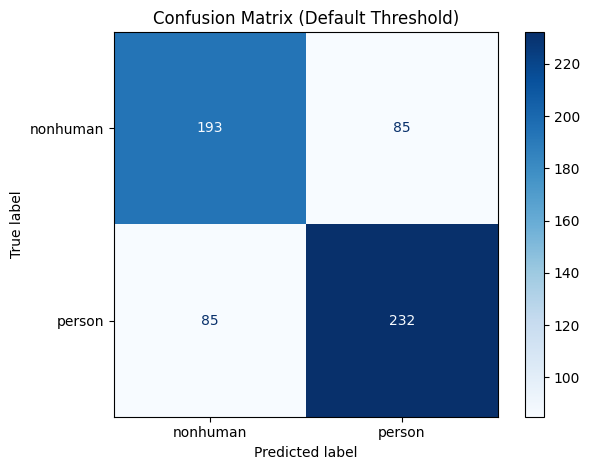

Default threshold confusion matrix plot saved to: /content/drive/MyDrive/COS429/cv_final_project/results_hog/hog_svc_confusion_matrix_default_threshold.png


In [52]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import os

y_pred_default = clf_final_hog.predict(X_test_final_hog)
cm_default = confusion_matrix(y_test_final_hog, y_pred_default)
disp = ConfusionMatrixDisplay(confusion_matrix=cm_default, display_labels=['nonhuman', 'person'])
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix (Default Threshold)")
plt.tight_layout()

cm_default_path = os.path.join(RESULTS_DIR, "hog_svc_confusion_matrix_default_threshold.png")
plt.savefig(cm_default_path, dpi=200)
plt.show()
print(f"Default threshold confusion matrix plot saved to: {cm_default_path}")

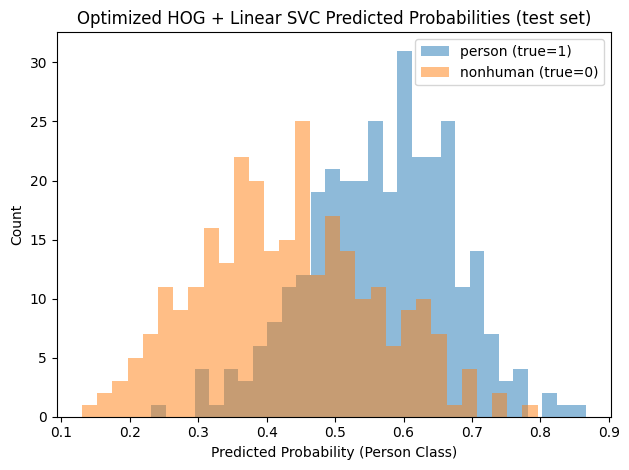

Histogram of predicted probabilities for optimized HOG model generated and saved.


In [48]:
import matplotlib.pyplot as plt
import numpy as np #

# convert decision scores to pseudo-probabilities using a sigmoid function
# a higher score generally means higher confidence in the positive class (person)
predicted_probabilities_person = 1 / (1 + np.exp(-scores_test_final_hog))

plt.figure()
plt.hist(predicted_probabilities_person[y_test_final_hog == 1], bins=30, alpha=0.5, label='person (true=1)')
plt.hist(predicted_probabilities_person[y_test_final_hog == 0], bins=30, alpha=0.5, label='nonhuman (true=0)')
plt.xlabel("Predicted Probability (Person Class)") # Updated x-axis label
plt.ylabel("Count")
plt.legend()
plt.title("Optimized HOG + Linear SVC Predicted Probabilities (test set)") # Updated title
plt.tight_layout()
plt.savefig(os.path.join(RESULTS_DIR, "hog_svc_probabilities_test_optimized.png"), dpi=200) # Changed filename
plt.show()
print("Histogram of predicted probabilities for optimized HOG model generated and saved.")

Building test HOG features (vis):   0%|          | 0/235 [00:00<?, ?it/s]

[test VIS HOG] X shape: (595, 9072), y shape: (595,)
[test VIS HOG] persons: 317, nonhumans: 278

Optimized HOG + SVM Results:
TP count: 232
FP count: 85
FN count: 85
TN count: 193


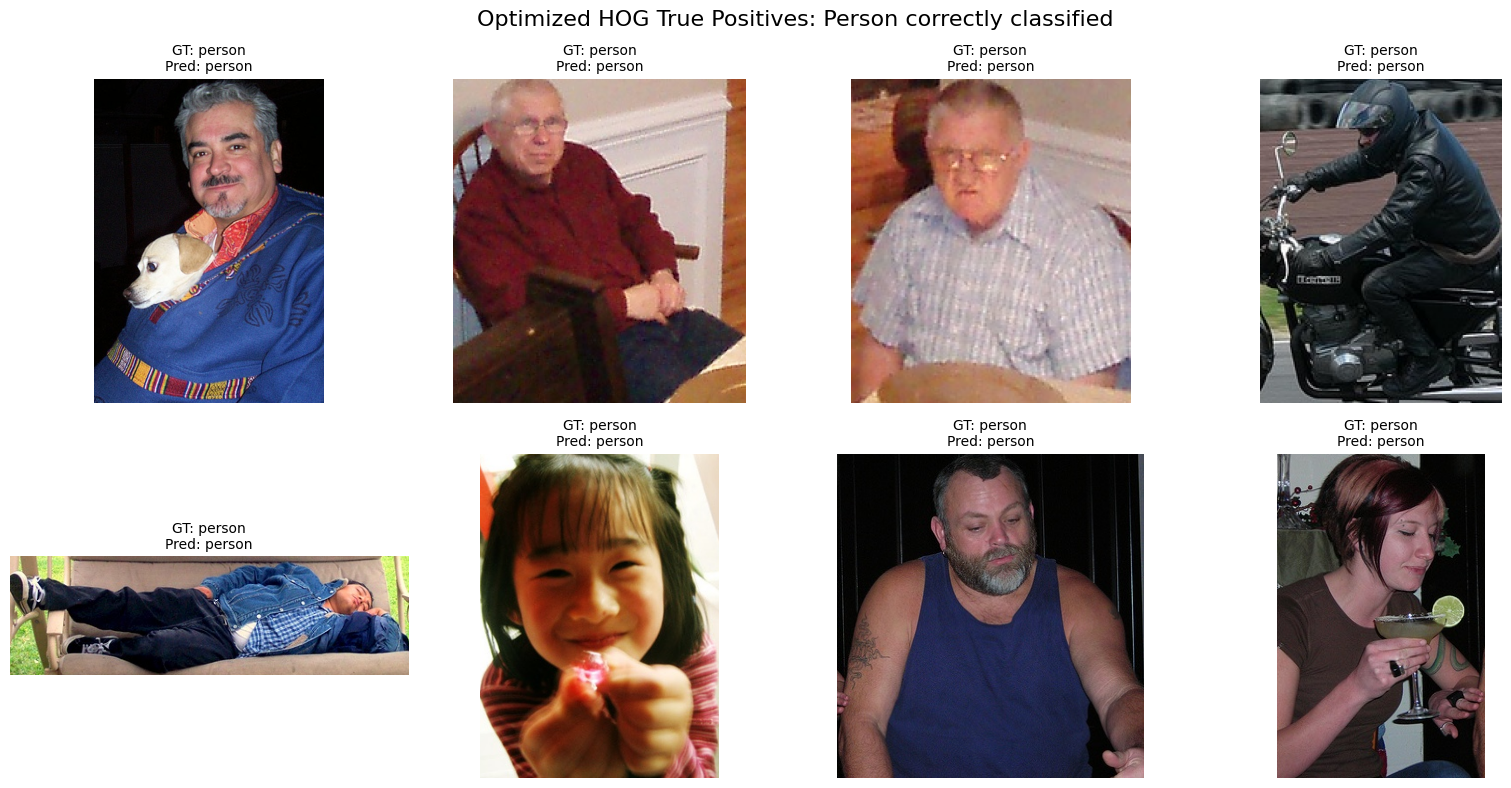

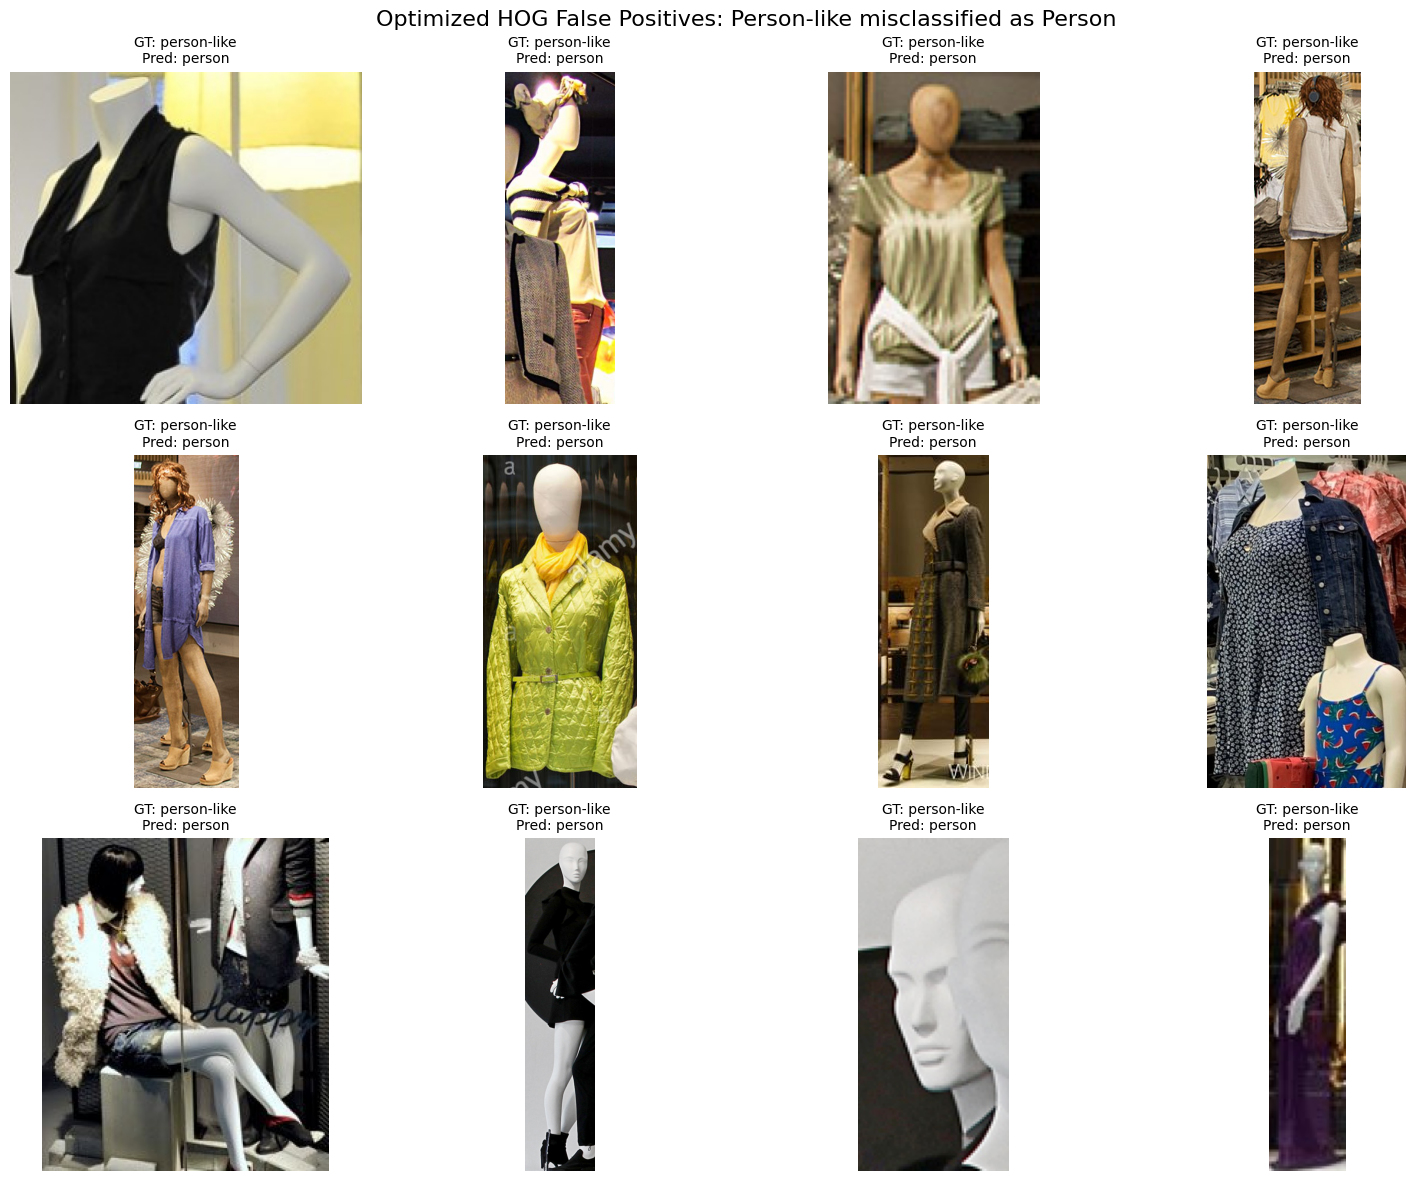

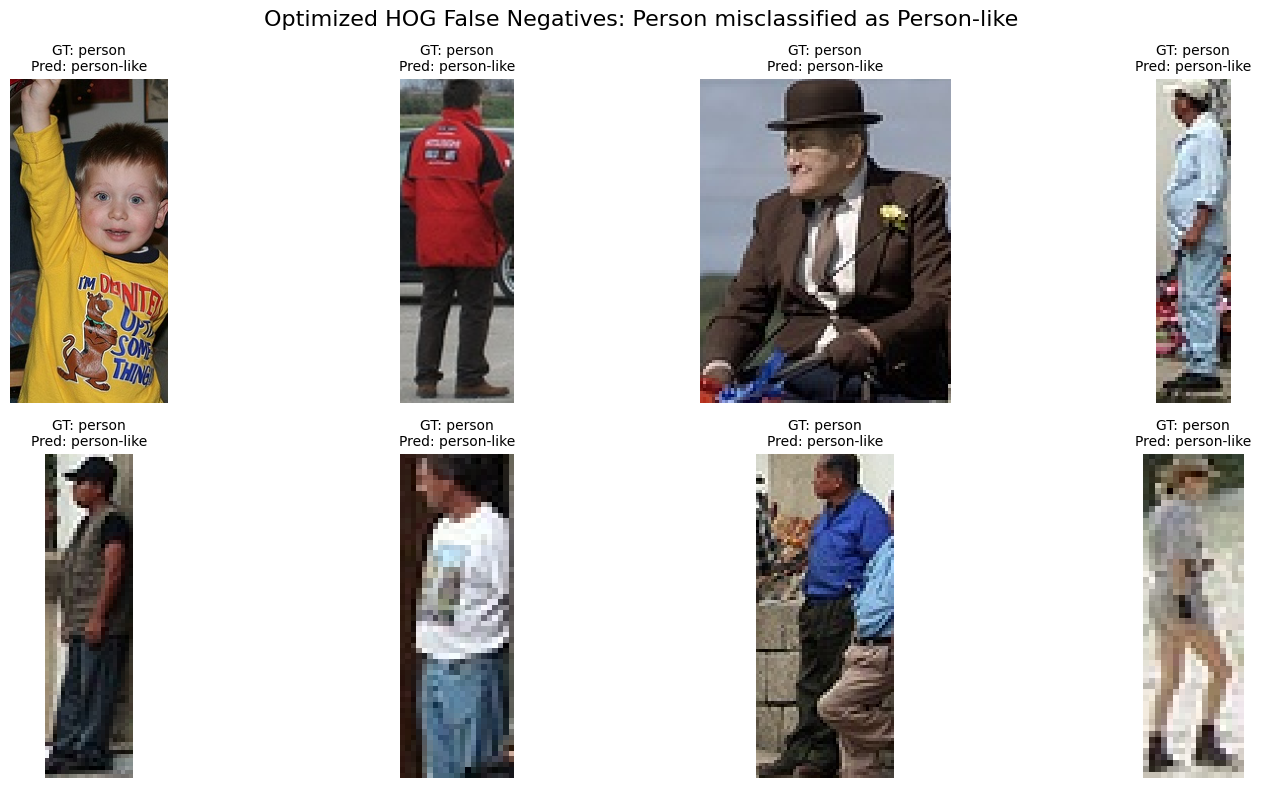

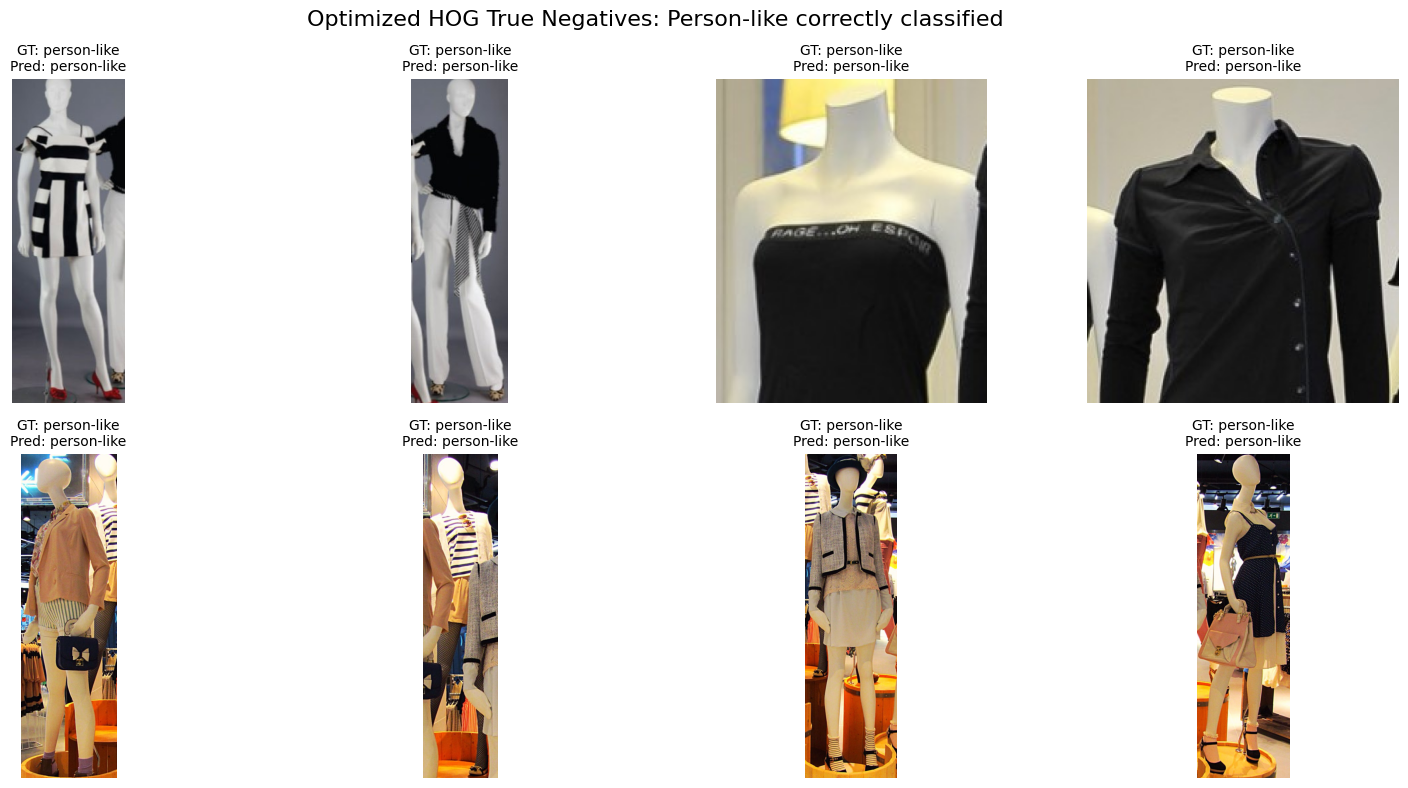

In [19]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from PIL import Image
import cv2
import numpy as np
from tqdm.notebook import tqdm

def build_hog_features_with_meta(samples_grouped, split_name, hog_params):
    """
    Given list of sample_groups (each representing an image with its annotations)
    compute HOG features for each bounding box using specified parameters, and return metadata.
    hog_params: dict containing 'win_size', 'block_size', 'block_stride', 'cell_size', 'nbins'
    """
    X_list = []
    y_list = []
    meta_list = []
    processed_boxes_count = 0

    win_size = hog_params['win_size']
    block_size = hog_params['block_size']
    block_stride = hog_params['block_stride']
    cell_size = hog_params['cell_size']
    nbins = hog_params['nbins']

    for sample_group in tqdm(samples_grouped, desc=f'Building {split_name} HOG features (vis)'):
        img_path = sample_group['img_path']
        img = cv2.imread(img_path)
        if img is None:
            # print(f"[{split_name}] Warning: could not read {img_path}")
            continue

        h, w = img.shape[:2]

        for annotation in sample_group['annotations']:
            xmin, ymin, xmax, ymax = annotation['bbox']
            y = annotation['y']

            # clamp to image bounds
            xmin_clamped = max(0, xmin)
            ymin_clamped = max(0, ymin)
            xmax_clamped = min(w - 1, xmax)
            ymax_clamped = min(h - 1, ymax)

            if xmax_clamped <= xmin_clamped or ymax_clamped <= ymin_clamped:
                continue

            crop = img[ymin_clamped:ymax_clamped, xmin_clamped:xmax_clamped]

            # use the parameterized HOG feature computation
            feat = compute_parameterized_hog_feature(
                crop, win_size=win_size, block_size=block_size,
                block_stride=block_stride, cell_size=cell_size, nbins=nbins
            )

            X_list.append(feat)
            y_list.append(y)
            meta_list.append({
                'img_path': img_path,
                'bbox': (xmin, ymin, xmax, ymax),
                'label': annotation['label'],
                'y': y,
                'split': sample_group['split']
            })
            processed_boxes_count += 1

    X = np.array(X_list, dtype=np.float32)
    y = np.array(y_list, dtype=np.int32)
    print(f"[{split_name} VIS HOG] X shape: {X.shape}, y shape: {y.shape}")
    print(f"[{split_name} VIS HOG] persons: {np.sum(y==1)}, nonhumans: {np.sum(y==0)}")
    return X, y, meta_list

# first get optimized HOG features and metadata for the test set
X_test_optimized_hog_vis, y_test_optimized_hog_vis, meta_test_optimized_hog_vis = build_hog_features_with_meta(test_samples, "test", best_hog_params)

# then get predictions from the trained optimized HOG SVC classifier
y_pred_test_optimized_hog_vis = clf_final_hog.predict(X_test_optimized_hog_vis)

# then calculate TP, FP, FN, TN indices for optimized HOG results
tp_idx_hog_opt = np.where((y_test_optimized_hog_vis == 1) & (y_pred_test_optimized_hog_vis == 1))[0]
fp_idx_hog_opt = np.where((y_test_optimized_hog_vis == 0) & (y_pred_test_optimized_hog_vis == 1))[0]
fn_idx_hog_opt = np.where((y_test_optimized_hog_vis == 1) & (y_pred_test_optimized_hog_vis == 0))[0]
tn_idx_hog_opt = np.where((y_test_optimized_hog_vis == 0) & (y_pred_test_optimized_hog_vis == 0))[0]

print("\nOptimized HOG + SVM Results:")
print("TP count:", len(tp_idx_hog_opt))
print("FP count:", len(fp_idx_hog_opt))
print("FN count:", len(fn_idx_hog_opt))
print("TN count:", len(tn_idx_hog_opt))

# re-define or adapt the show_crops function for general use
def show_crops_vis(indices, title, meta_data, y_true_data, y_pred_data, max_n=8):
    """
    indices: list/array of indices into meta_data / y_true_data / y_pred_data
    Shows up to max_n crops with GT + predicted label.
    """
    n = min(max_n, len(indices))
    if n == 0:
        print(f"No examples for: {title}")
        return

    ncols = 4
    nrows = int(np.ceil(n / ncols))

    plt.figure(figsize=(4 * ncols, 4 * nrows))
    for i, idx in enumerate(indices[:n]):
        s = meta_data[idx]
        img = cv2.imread(s['img_path'])
        xmin, ymin, xmax, ymax = s['bbox']
        h, w = img.shape[:2]
        xmin = max(0, xmin); ymin = max(0, ymin)
        xmax = min(w - 1, xmax); ymax = min(h - 1, ymax)
        crop = img[ymin:ymax, xmin:xmax]

        # convert BGR → RGB for matplotlib
        crop_rgb = cv2.cvtColor(crop, cv2.COLOR_BGR2RGB)

        gt = "person" if y_true_data[idx] == 1 else "person-like"
        pred = "person" if y_pred_data[idx] == 1 else "person-like"

        ax = plt.subplot(nrows, ncols, i + 1)
        ax.imshow(crop_rgb)
        ax.axis("off")
        ax.set_title(f"GT: {gt}\nPred: {pred}", fontsize=10)

    plt.suptitle(title, fontsize=16)
    plt.tight_layout()
    plt.show()

# visualize results for Optimized HOG + Linear SVM
show_crops_vis(tp_idx_hog_opt, "Optimized HOG True Positives: Person correctly classified", meta_test_optimized_hog_vis, y_test_optimized_hog_vis, y_pred_test_optimized_hog_vis, max_n=8)
show_crops_vis(fp_idx_hog_opt, "Optimized HOG False Positives: Person-like misclassified as Person", meta_test_optimized_hog_vis, y_test_optimized_hog_vis, y_pred_test_optimized_hog_vis, max_n=12)
show_crops_vis(fn_idx_hog_opt, "Optimized HOG False Negatives: Person misclassified as Person-like", meta_test_optimized_hog_vis, y_test_optimized_hog_vis, y_pred_test_optimized_hog_vis, max_n=8)
show_crops_vis(tn_idx_hog_opt, "Optimized HOG True Negatives: Person-like correctly classified", meta_test_optimized_hog_vis, y_test_optimized_hog_vis, y_pred_test_optimized_hog_vis, max_n=8)


In [20]:
import numpy as np
from sklearn.metrics import precision_score, recall_score, f1_score

def iou(bbox1, bbox2):
    """
    Calculate the Intersection over Union (IoU) of two bounding boxes.
    Each bounding box is in format (xmin, ymin, xmax, ymax).
    """
    # determine the coordinates of the intersection rectangle
    x_left = max(bbox1[0], bbox2[0])
    y_top = max(bbox1[1], bbox2[1])
    x_right = min(bbox1[2], bbox2[2])
    y_bottom = min(bbox1[3], bbox2[3])

    # if there is no intersection, return 0
    if x_right < x_left or y_bottom < y_top:
        return 0.0

    intersection_area = (x_right - x_left) * (y_bottom - y_top)
    bbox1_area = (bbox1[2] - bbox1[0]) * (bbox1[3] - bbox1[1])
    bbox2_area = (bbox2[2] - bbox2[0]) * (bbox2[3] - bbox2[1])
    union_area = float(bbox1_area + bbox2_area - intersection_area)

    # handle case where union_area might be zero to avoid division by zero
    if union_area == 0:
        return 0.0

    return intersection_area / union_area

def compute_classification_metrics_at_threshold(y_true, scores, threshold):
    """
    Compute precision, recall, and F1-score for the positive class at a given threshold.
    """
    # Convert scores to binary predictions
    y_pred = (scores >= threshold).astype(int)

    precision = precision_score(y_true, y_pred, pos_label=1, zero_division=0)
    recall = recall_score(y_true, y_pred, pos_label=1, zero_division=0)
    f1 = f1_score(y_true, y_pred, pos_label=1, zero_division=0)

    return precision, recall, f1

def find_best_score_threshold_by_f1(y_true, scores):
    """
    Find the optimal score threshold that maximizes the F1-score for the positive class.
    Returns the best threshold and corresponding precision, recall, and F1-score.
    """
    best_f1 = -1
    best_threshold = None
    best_precision = 0
    best_recall = 0

    # Generate potential thresholds from the unique scores
    # Add a small epsilon to unique scores to ensure all distinct points are considered,
    # and also include a very high threshold to cover cases where all are negative.
    candidate_thresholds = np.unique(scores)
    if len(candidate_thresholds) == 0:
        return 0.0, 0.0, 0.0, 0.0 # No scores, no valid threshold

    # Add max score + epsilon to ensure that the highest score also acts as a threshold.
    # This covers scenarios where all predictions could be negative (if threshold is too high)
    candidate_thresholds = np.sort(np.concatenate(([np.min(scores) - 0.1], candidate_thresholds, [np.max(scores) + 0.1])))


    for threshold in candidate_thresholds:
        precision, recall, f1 = compute_classification_metrics_at_threshold(y_true, scores, threshold)

        if f1 > best_f1:
            best_f1 = f1
            best_threshold = threshold
            best_precision = precision
            best_recall = recall

    return best_threshold, best_precision, best_recall, best_f1

print("Evaluation helper functions defined: iou, compute_classification_metrics_at_threshold, find_best_score_threshold_by_f1.")

Evaluation helper functions defined: iou, compute_classification_metrics_at_threshold, find_best_score_threshold_by_f1.


In [51]:
from sklearn.metrics import average_precision_score, precision_recall_curve, confusion_matrix
import numpy as np

# calculate Average Precision (AP) for the 'person' class (positive class)
pr_auc_optimized_hog = average_precision_score(y_test_final_hog, scores_test_final_hog, pos_label=1)
print(f"Average Precision (AP) for person class: {pr_auc_optimized_hog:.4f}")

# find the optimal threshold for F1-score
best_threshold_f1, best_precision_f1, best_recall_f1, best_f1_score = find_best_score_threshold_by_f1(y_test_final_hog, scores_test_final_hog)

print(f"\nOptimal Threshold (max F1-score for person): {best_threshold_f1:.4f}")
print(f"Precision at optimal threshold: {best_precision_f1:.4f}")
print(f"Recall at optimal threshold: {best_recall_f1:.4f}")
print(f"F1-score at optimal threshold: {best_f1_score:.4f}")

# Calculate False Positive Rate (FPR) at optimal threshold
y_pred_optimal = (scores_test_final_hog >= best_threshold_f1).astype(int)
tn, fp, fn, tp = confusion_matrix(y_test_final_hog, y_pred_optimal).ravel()
fpr = fp / (fp + tn)
print(f"False Positive Rate at optimal threshold: {fpr:.4f}")

Average Precision (AP) for person class: 0.7866

Optimal Threshold (max F1-score for person): -0.2767
Precision at optimal threshold: 0.6841
Recall at optimal threshold: 0.9085
F1-score at optimal threshold: 0.7805
False Positive Rate at optimal threshold: 0.4784


In [31]:
import json
import os


summary_path = os.path.join(RESULTS_DIR, "summary_hog_svm_optimized.json")
with open(summary_path, 'r') as f:
  summary_data = json.load(f)

if summary_data:
    pr_auc_person_test = summary_data.get('pr_auc_person_test')
    pr_auc_nonhuman_test = summary_data.get('pr_auc_nonhuman_test')

    if pr_auc_person_test is not None and pr_auc_nonhuman_test is not None:
        mean_average_precision = (pr_auc_person_test + pr_auc_nonhuman_test) / 2
        print(f"Mean Average Precision (mAP) on the test set: {mean_average_precision:.4f}")
    else:
        print("Required AUC metrics are missing from the summary data.")
else:
    print("Summary data not available. Please ensure the evaluation and summary generation cells have been run.")

Mean Average Precision (mAP) on the test set: 0.7904


In [32]:
import pandas as pd

# recalculate confusion counts at the optimal F1-score threshold
y_pred_at_best_threshold = (scores_test_final_hog >= best_threshold_f1).astype(int)

tp_count_f1 = np.sum((y_test_final_hog == 1) & (y_pred_at_best_threshold == 1))
fp_count_f1 = np.sum((y_test_final_hog == 0) & (y_pred_at_best_threshold == 1))
fn_count_f1 = np.sum((y_test_final_hog == 1) & (y_pred_at_best_threshold == 0))
tn_count_f1 = np.sum((y_test_final_hog == 0) & (y_pred_at_best_threshold == 0))

print(f"\nConfusion Counts at Optimal F1-score Threshold ({best_threshold_f1:.4f}):")
print(f"True Positives (TP): {tp_count_f1}")
print(f"False Positives (FP): {fp_count_f1}")
print(f"False Negatives (FN): {fn_count_f1}")
print(f"True Negatives (TN): {tn_count_f1}")

# categorize False Positives (FP) by their original labels
# fp_idx_hog_opt from previous step was based on default threshold, recreate based on best_threshold_f1
fp_indices_at_best_threshold = np.where((y_test_final_hog == 0) & (y_pred_at_best_threshold == 1))[0]

fp_categories = {}
for idx in fp_indices_at_best_threshold:
    original_label = meta_test_optimized_hog_vis[idx]['label']
    if original_label not in fp_categories:
        fp_categories[original_label] = 0
    fp_categories[original_label] += 1

print("\nFalse Positive Breakdown by Original Label:")
for label, count in fp_categories.items():
    print(f"  {label}: {count}")

conf_matrix = confusion_matrix(y_test_final_hog, y_pred_at_best_threshold)
conf_matrix_df = pd.DataFrame(conf_matrix, index=['True Negative (0)', 'True Positive (1)'], columns=['Predicted Negative (0)', 'Predicted Positive (1)'])
print("\nConfusion Matrix (at optimal F1-score threshold):")
print(conf_matrix_df)



Confusion Counts at Optimal F1-score Threshold (-0.2767):
True Positives (TP): 288
False Positives (FP): 133
False Negatives (FN): 29
True Negatives (TN): 145

False Positive Breakdown by Original Label:
  person-like: 133

Confusion Matrix (at optimal F1-score threshold):
                   Predicted Negative (0)  Predicted Positive (1)
True Negative (0)                     145                     133
True Positive (1)                      29                     288


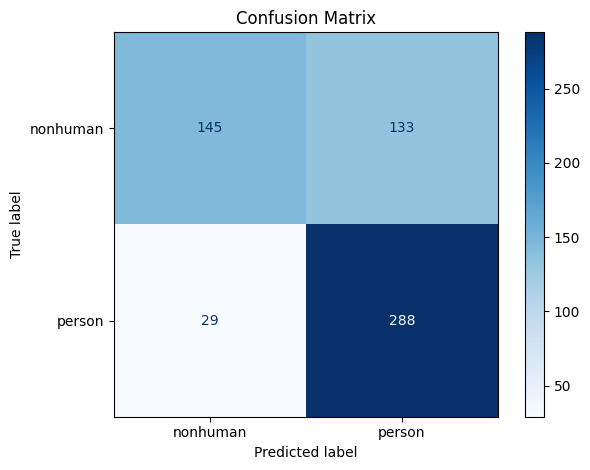

Confusion matrix plot saved to: /content/drive/MyDrive/COS429/cv_final_project/results_hog/hog_svc_confusion_matrix_optimized.png


In [47]:
from sklearn.metrics import ConfusionMatrixDisplay
import matplotlib.pyplot as plt

disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=['nonhuman', 'person'])
disp.plot(cmap=plt.cm.Blues)
plt.title(f"Confusion Matrix")
plt.tight_layout()

cm_save_path = os.path.join(RESULTS_DIR, "hog_svc_confusion_matrix_optimized.png")
plt.savefig(cm_save_path, dpi=200)
plt.show()
print(f"Confusion matrix plot saved to: {cm_save_path}")

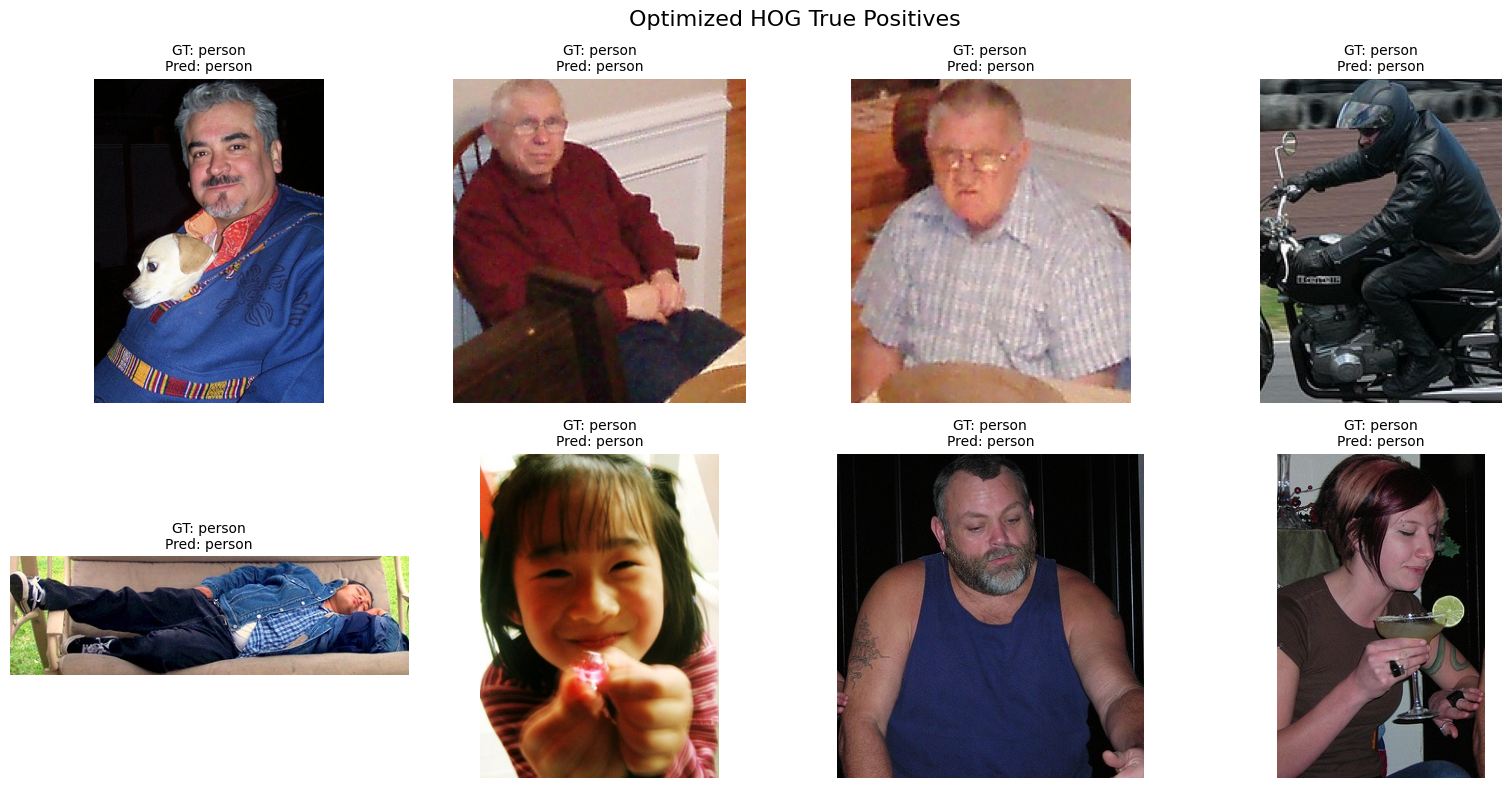

Optimized HOG True Positives visualization generated and saved to: /content/drive/MyDrive/COS429/cv_final_project/results_hog/hog_svm_optimized_tp_grid.png


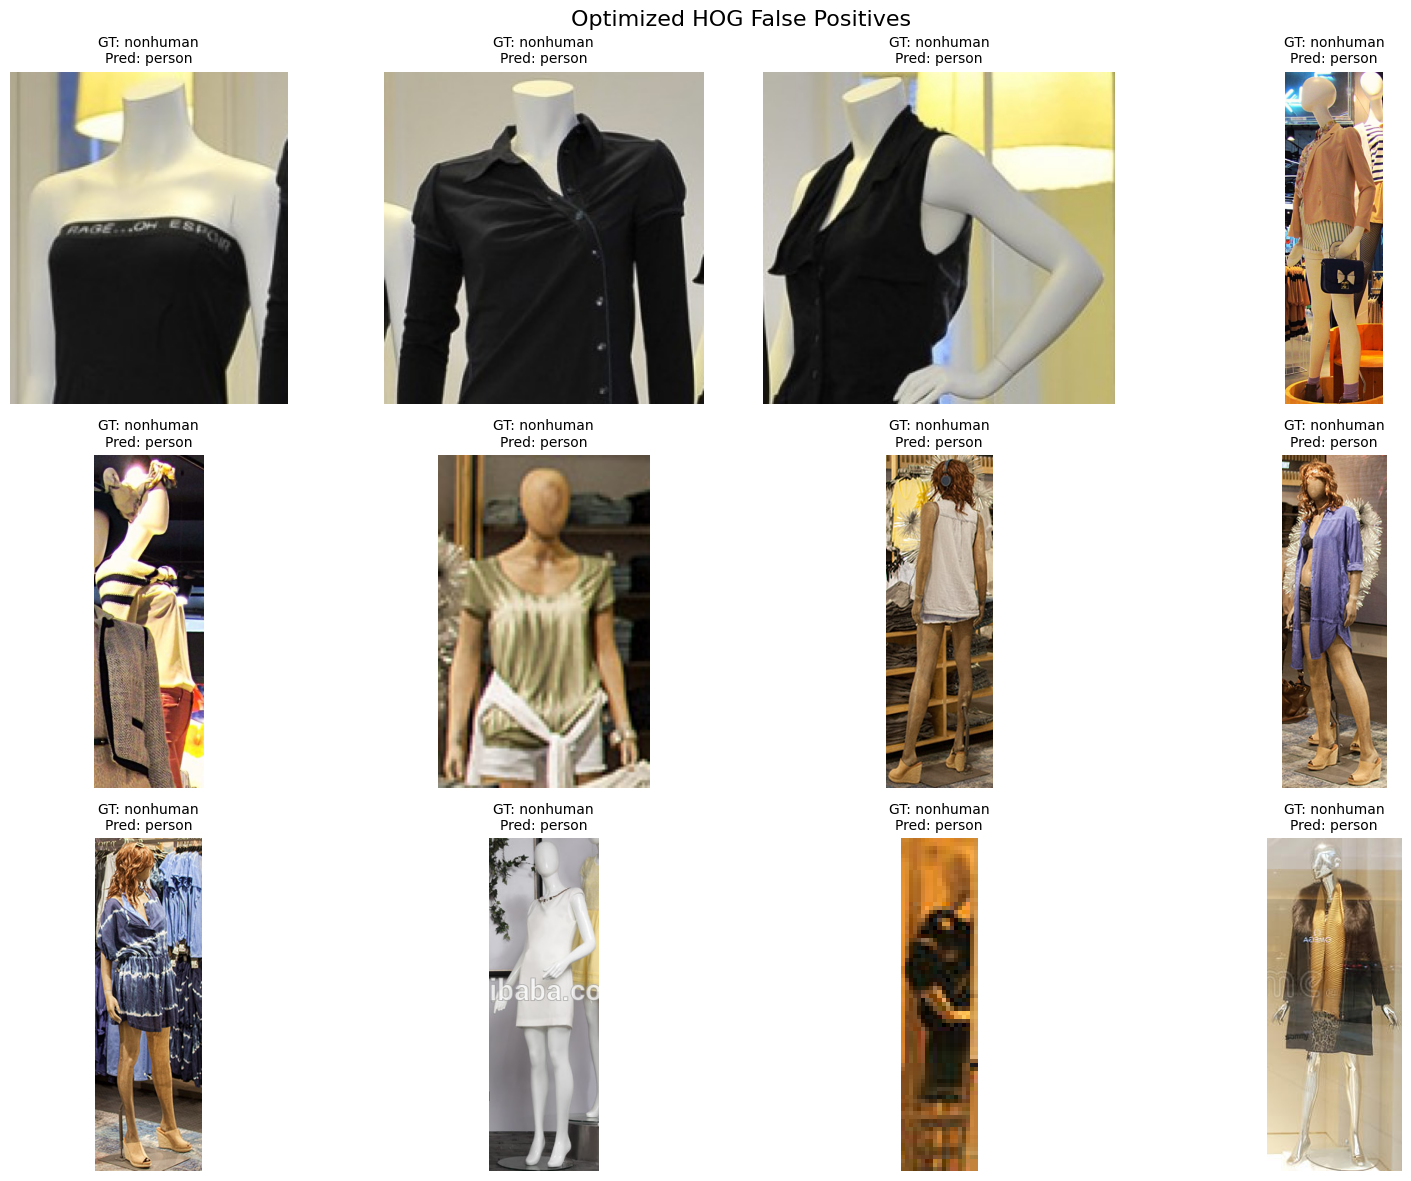

Optimized HOG False Positives visualization generated and saved to: /content/drive/MyDrive/COS429/cv_final_project/results_hog/hog_svm_optimized_fp_grid.png


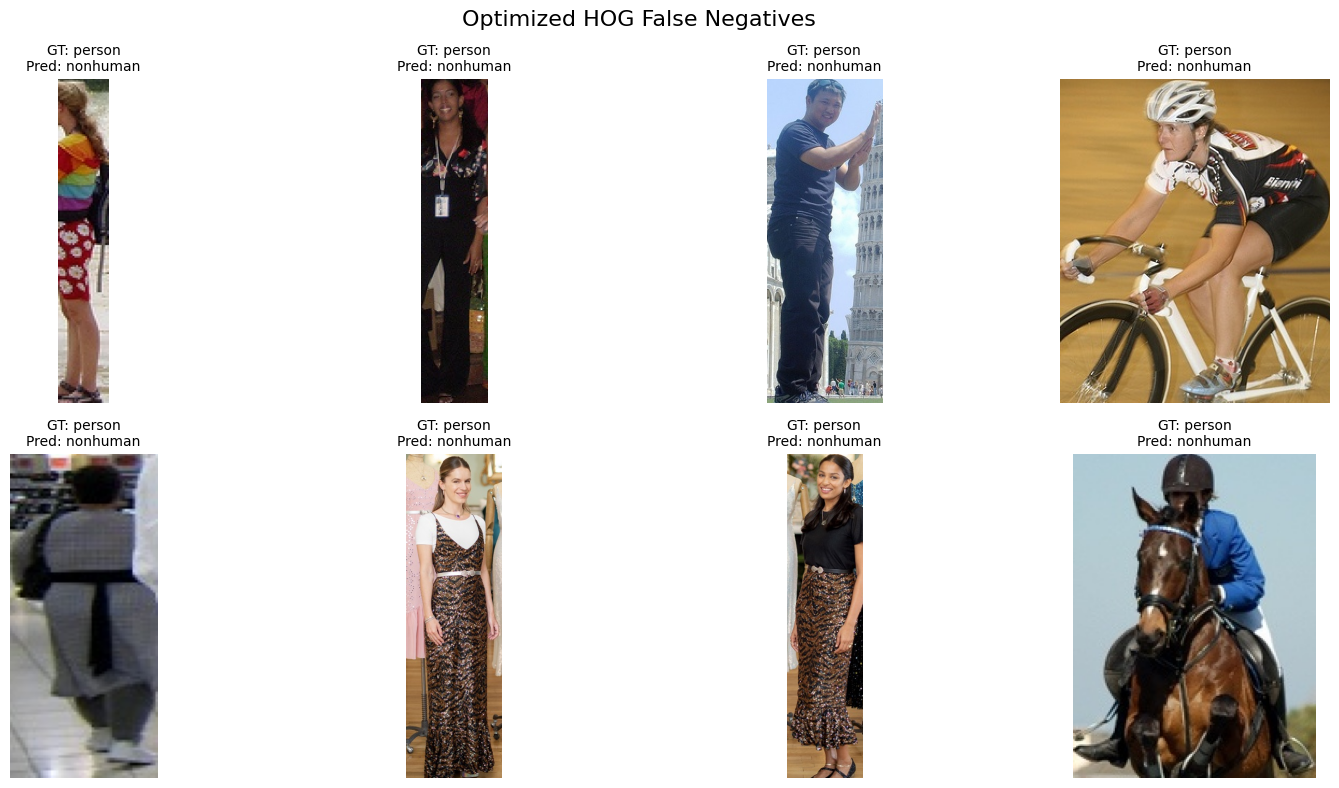

Optimized HOG False Negatives visualization generated and saved to: /content/drive/MyDrive/COS429/cv_final_project/results_hog/hog_svm_optimized_fn_grid.png


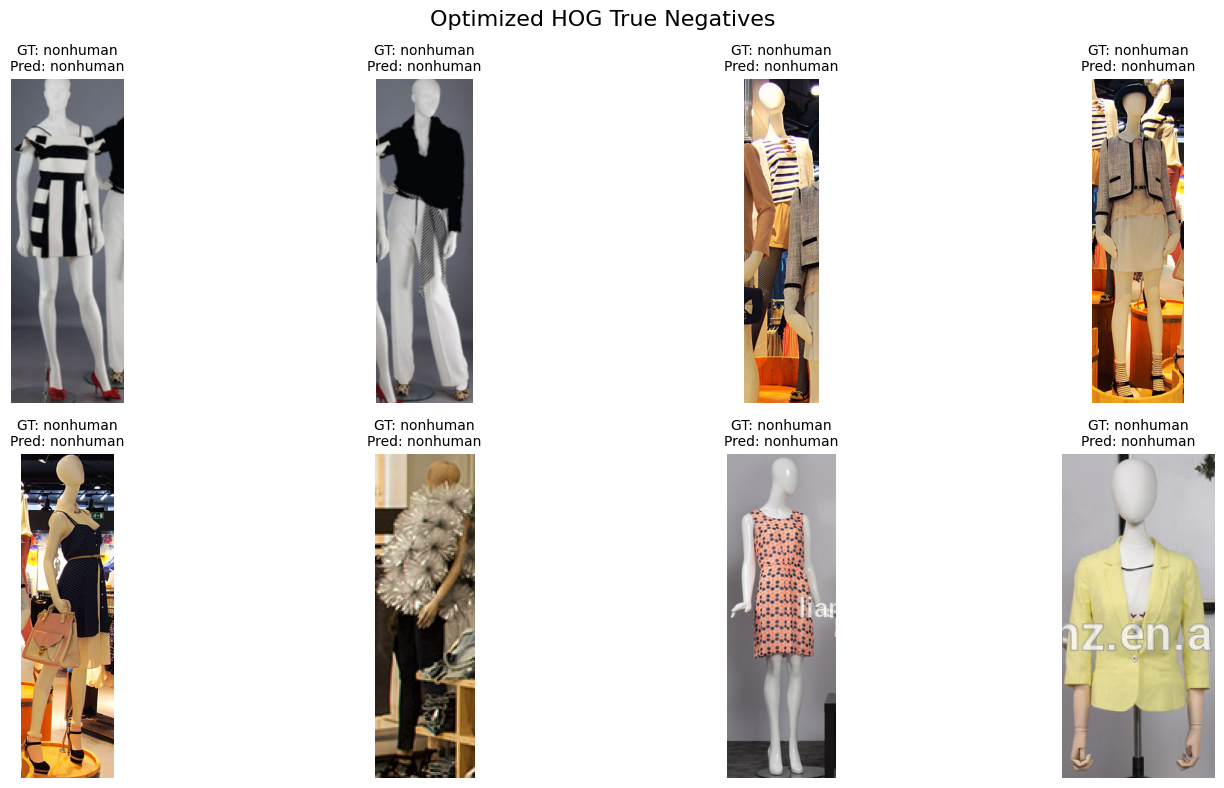

Optimized HOG True Negatives visualization generated and saved to: /content/drive/MyDrive/COS429/cv_final_project/results_hog/hog_svm_optimized_tn_grid.png


In [44]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from PIL import Image
import cv2
import numpy as np
from tqdm.notebook import tqdm

# Recalculate TP, FP, FN, TN indices based on predictions at the best F1-score threshold
tp_idx_hog_opt_new = np.where((y_test_optimized_hog_vis == 1) & (y_pred_at_best_threshold == 1))[0]
fp_idx_hog_opt_new = np.where((y_test_optimized_hog_vis == 0) & (y_pred_at_best_threshold == 1))[0]
fn_idx_hog_opt_new = np.where((y_test_optimized_hog_vis == 1) & (y_pred_at_best_threshold == 0))[0]
tn_idx_hog_opt_new = np.where((y_test_optimized_hog_vis == 0) & (y_pred_at_best_threshold == 0))[0]

# Re-define or adapt the show_crops function for general use with saving capability
def show_crops_vis_and_save(indices, title, file_prefix, meta_data, y_true_data, y_pred_data, max_n=8):
    """
    indices: list/array of indices into meta_data / y_true_data / y_pred_data
    Shows up to max_n crops with GT + predicted label and saves the figure.
    """
    n = min(max_n, len(indices))
    if n == 0:
        print(f"No examples for: {title}")
        return

    ncols = 4
    nrows = int(np.ceil(n / ncols))

    plt.figure(figsize=(4 * ncols, 4 * nrows))
    for i, idx in enumerate(indices[:n]):
        s = meta_data[idx]
        img = cv2.imread(s['img_path'])
        xmin, ymin, xmax, ymax = s['bbox']
        h, w = img.shape[:2]
        xmin = max(0, xmin); ymin = max(0, ymin)
        xmax = min(w - 1, xmax); ymax = min(h - 1, ymax)
        crop = img[ymin:ymax, xmin:xmax]

        # convert BGR → RGB for matplotlib
        crop_rgb = cv2.cvtColor(crop, cv2.COLOR_BGR2RGB)

        gt = "person" if y_true_data[idx] == 1 else "nonhuman"
        pred = "person" if y_pred_data[idx] == 1 else "nonhuman"

        ax = plt.subplot(nrows, ncols, i + 1)
        ax.imshow(crop_rgb)
        ax.axis("off")
        ax.set_title(f"GT: {gt}\nPred: {pred}", fontsize=10)

    plt.suptitle(title, fontsize=16)
    plt.tight_layout()
    save_path = os.path.join(RESULTS_DIR, f"hog_svm_optimized_{file_prefix}.png")
    plt.savefig(save_path, dpi=200)
    plt.show()
    print(f"{title} visualization generated and saved to: {save_path}")

# Visualize results for Optimized HOG + Linear SVC with best F1 threshold
show_crops_vis_and_save(tp_idx_hog_opt_new, "Optimized HOG True Positives", "tp_grid", meta_test_optimized_hog_vis, y_test_optimized_hog_vis, y_pred_at_best_threshold, max_n=8)
show_crops_vis_and_save(fp_idx_hog_opt_new, "Optimized HOG False Positives", "fp_grid", meta_test_optimized_hog_vis, y_test_optimized_hog_vis, y_pred_at_best_threshold, max_n=12)
show_crops_vis_and_save(fn_idx_hog_opt_new, "Optimized HOG False Negatives", "fn_grid", meta_test_optimized_hog_vis, y_test_optimized_hog_vis, y_pred_at_best_threshold, max_n=8)
show_crops_vis_and_save(tn_idx_hog_opt_new, "Optimized HOG True Negatives", "tn_grid", meta_test_optimized_hog_vis, y_test_optimized_hog_vis, y_pred_at_best_threshold, max_n=8)



In [36]:
X_val_final_hog, y_val_final_hog = build_hog_features_with_params(val_samples, "val", best_hog_params)

print("Optimized HOG features extracted for validation set.")

Building val features with HOG params {'win_size': (64, 128), 'block_size': (24, 24), 'block_stride': (8, 8), …

[val] X shape: (333, 9072), y shape: (333,) for HOG params {'win_size': (64, 128), 'block_size': (24, 24), 'block_stride': (8, 8), 'cell_size': (8, 8), 'nbins': 12}
Optimized HOG features extracted for validation set.


In [37]:
scores_val_final_hog = clf_final_hog.decision_function(X_val_final_hog)

print("Decision function scores computed for the validation set.")

Decision function scores computed for the validation set.


Average Precision (AP) for person class on validation set: 0.8571
Precision-Recall curve data computed for validation set.


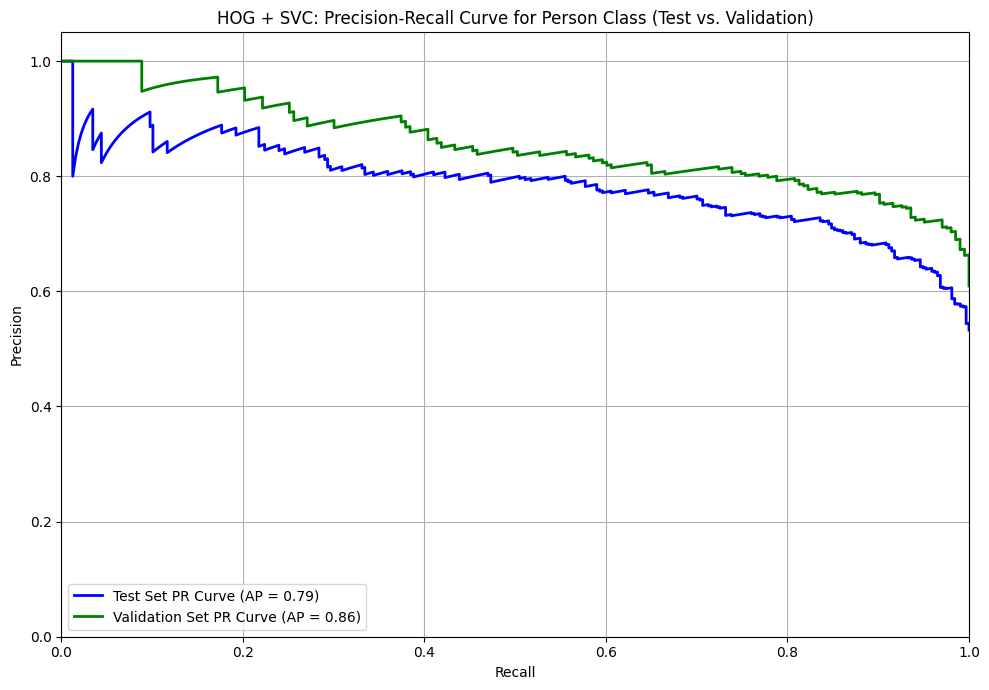

Precision-Recall curve for person class (Test vs. Validation) generated and saved to: /content/drive/MyDrive/COS429/cv_final_project/results_hog/hog_svm_pr_curve_person_test_vs_val.png


In [39]:
from sklearn.metrics import average_precision_score, precision_recall_curve
import matplotlib.pyplot as plt
import os

pr_auc_val_optimized_hog = average_precision_score(y_val_final_hog, scores_val_final_hog, pos_label=1)
print(f"Average Precision (AP) for person class on validation set: {pr_auc_val_optimized_hog:.4f}")

precision_val, recall_val, _ = precision_recall_curve(y_val_final_hog, scores_val_final_hog, pos_label=1)
print("Precision-Recall curve data computed for validation set.")

precision, recall, _ = precision_recall_curve(y_test_final_hog, scores_test_final_hog, pos_label=1)

plt.figure(figsize=(10, 7))
plt.plot(recall, precision, color='blue', lw=2, label=f'Test Set PR Curve (AP = {pr_auc_optimized_hog:.2f})')
plt.plot(recall_val, precision_val, color='green', lw=2, label=f'Validation Set PR Curve (AP = {pr_auc_val_optimized_hog:.2f})')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('HOG + SVC: Precision-Recall Curve for Person Class (Test vs. Validation)')
plt.legend(loc='lower left')
plt.grid(True)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.tight_layout()
pr_curve_person_test_val_path = os.path.join(RESULTS_DIR, "hog_svm_pr_curve_person_test_vs_val.png")
plt.savefig(pr_curve_person_test_val_path, dpi=200)

plt.show()
print(f"Precision-Recall curve for person class (Test vs. Validation) generated and saved to: {pr_curve_person_test_val_path}")

Average Precision (AP) for nonhuman class on test set: 0.7942
Precision-Recall curve data computed for nonhuman test set.
Average Precision (AP) for nonhuman class on validation set: 0.7819
Precision-Recall curve data computed for nonhuman validation set.


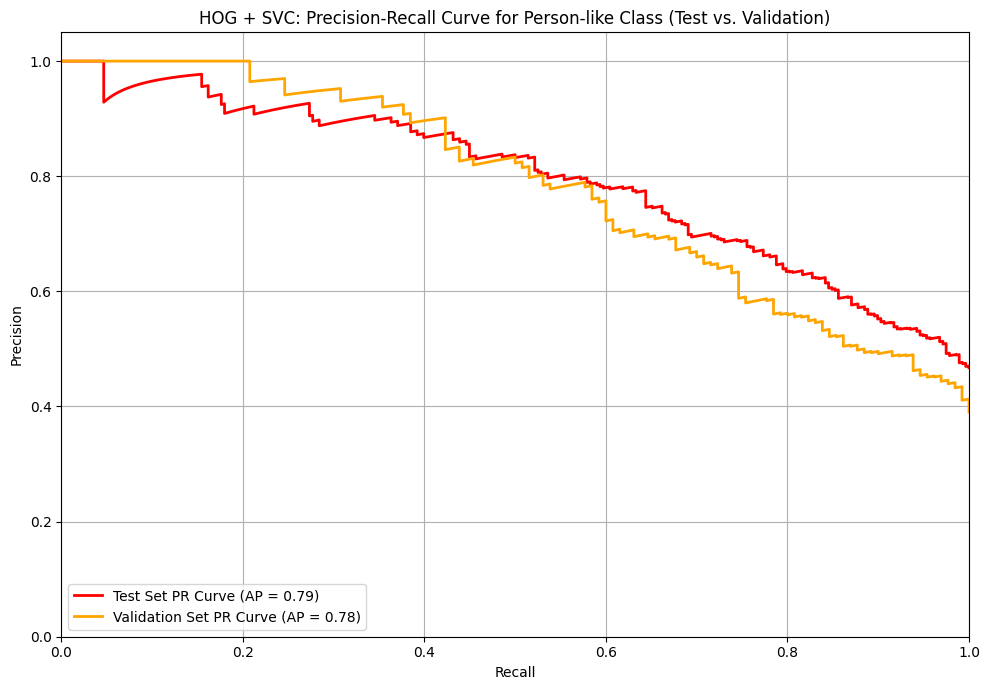

Precision-Recall curve for nonhuman class (Test vs. Validation) generated and saved to: /content/drive/MyDrive/COS429/cv_final_project/results_hog/hog_svc_pr_curve_nonhuman_test_vs_val.png


In [50]:
from sklearn.metrics import average_precision_score, precision_recall_curve
import matplotlib.pyplot as plt
import os

# Nonhuman Class (label 0)
# For nonhuman class, we invert the labels and negate the scores
# to treat 'nonhuman' as the positive class for PR curve calculation.

y_test_nonhuman_true = 1 - y_test_final_hog  # Invert labels: 0 becomes 1, 1 becomes 0
scores_test_nonhuman = -scores_test_final_hog  # Negate scores
pr_auc_nonhuman_test = average_precision_score(y_test_nonhuman_true, scores_test_nonhuman, pos_label=1)
print(f"Average Precision (AP) for nonhuman class on test set: {pr_auc_nonhuman_test:.4f}")

precision_nonhuman_test, recall_nonhuman_test, _ = precision_recall_curve(y_test_nonhuman_true, scores_test_nonhuman, pos_label=1)
print("Precision-Recall curve data computed for nonhuman test set.")

y_val_nonhuman_true = 1 - y_val_final_hog  # Invert labels
scores_val_nonhuman = -scores_val_final_hog  # Negate scores
pr_auc_nonhuman_val = average_precision_score(y_val_nonhuman_true, scores_val_nonhuman, pos_label=1)
print(f"Average Precision (AP) for nonhuman class on validation set: {pr_auc_nonhuman_val:.4f}")

precision_nonhuman_val, recall_nonhuman_val, _ = precision_recall_curve(y_val_nonhuman_true, scores_val_nonhuman, pos_label=1)
print("Precision-Recall curve data computed for nonhuman validation set.")

plt.figure(figsize=(10, 7))
# Added label argument here
plt.plot(recall_nonhuman_test, precision_nonhuman_test, color='red', lw=2, label=f'Test Set PR Curve (AP = {pr_auc_nonhuman_test:.2f})')
plt.plot(recall_nonhuman_val, precision_nonhuman_val, color='orange', lw=2, label=f'Validation Set PR Curve (AP = {pr_auc_nonhuman_val:.2f})')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('HOG + SVC: Precision-Recall Curve for Person-like Class (Test vs. Validation)')
plt.legend(loc='lower left')
plt.grid(True)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.tight_layout()

pr_curve_nonhuman_test_val_path = os.path.join(RESULTS_DIR, "hog_svc_pr_curve_nonhuman_test_vs_val.png")
plt.savefig(pr_curve_nonhuman_test_val_path, dpi=200)
plt.show()
print(f"Precision-Recall curve for nonhuman class (Test vs. Validation) generated and saved to: {pr_curve_nonhuman_test_val_path}")

In [41]:
import json
import os

MODEL_NAME = "hog_svc_optimized"
summary_filename = f"summary_{MODEL_NAME}.json"
summary_path = os.path.join(RESULTS_DIR, summary_filename)

summary_metrics = {
    "model": MODEL_NAME,
    "best_hog_parameters": {
        "win_size": best_hog_params['win_size'],
        "block_size": best_hog_params['block_size'],
        "block_stride": best_hog_params['block_stride'],
        "cell_size": best_hog_params['cell_size'],
        "nbins": best_hog_params['nbins']
    },
    "test_set_metrics": {
        "accuracy": float(best_metrics['accuracy'] if 'accuracy' in best_metrics else 0.0),
        "f1_nonhuman_tuned_params": float(best_metrics['f1_nonhuman'] if 'f1_nonhuman' in best_metrics else 0.0),
        "f1_person_tuned_params": float(best_metrics['f1_person'] if 'f1_person' in best_metrics else 0.0),
        "roc_auc_default_thresh": float(roc_auc_final_hog),
        "pr_auc_default_thresh": float(pr_auc_final_hog),
        "optimal_f1_threshold_person": float(best_threshold_f1),
        "precision_at_optimal_f1_person": float(best_precision_f1),
        "recall_at_optimal_f1_person": float(best_recall_f1),
        "f1_score_at_optimal_f1_person": float(best_f1_score),
        "confusion_counts_at_optimal_f1_person": {
            "True Positives": int(tp_count_f1),
            "False Positives": int(fp_count_f1),
            "False Negatives": int(fn_count_f1),
            "True Negatives": int(tn_count_f1)
        },
        "false_positive_breakdown": {k: int(v) for k, v in fp_categories.items()}
    },
    "pr_auc_person_test": float(pr_auc_optimized_hog),
    "pr_auc_person_validation": float(pr_auc_val_optimized_hog),
    "pr_auc_nonhuman_test": float(pr_auc_nonhuman_test),
    "pr_auc_nonhuman_validation": float(pr_auc_nonhuman_val)
}

with open(summary_path, 'w') as f:
    json.dump(summary_metrics, f, indent=4)

print(f"Evaluation summary saved to: {summary_path}")
print("Overall evaluation complete.")

Evaluation summary saved to: /content/drive/MyDrive/COS429/cv_final_project/results_hog/summary_hog_svc_optimized.json
Overall evaluation complete.


In [42]:
false_negative_rate = fn_count_f1 / (fn_count_f1 + tp_count_f1)
print(f"False Negative Rate (person -> person-like): {false_negative_rate:.4f} ({fn_count_f1}/{fn_count_f1 + tp_count_f1})")
print("This represents the rate at which actual 'person' instances were incorrectly classified as 'person-like' (nonhuman).")

False Negative Rate (person -> person-like): 0.0915 (29/317)
This represents the rate at which actual 'person' instances were incorrectly classified as 'person-like' (nonhuman).


In [43]:
import json
import os

# Ensure RESULTS_DIR is defined if not already in the kernel state
if 'RESULTS_DIR' not in locals():
    PROJECT_ROOT = "/content/drive/MyDrive/COS429/cv_final_project"
    RESULTS_DIR = os.path.join(PROJECT_ROOT, "results_hog")

MODEL_NAME = "hog_svm_optimized"
summary_filename = f"summary_{MODEL_NAME}.json"
summary_path = os.path.join(RESULTS_DIR, summary_filename)

# Load the summary JSON file
try:
    with open(summary_path, 'r') as f:
        summary_data = json.load(f)
    print(f"Successfully loaded summary from: {summary_path}")
except FileNotFoundError:
    print(f"Error: Summary file not found at {summary_path}")
    summary_data = None
except Exception as e:
    print(f"Error loading summary file: {e}")
    summary_data = None

Successfully loaded summary from: /content/drive/MyDrive/COS429/cv_final_project/results_hog/summary_hog_svm_optimized.json
